In [4]:
import numpy as np
import pandas as pd
import json
import os
import pennylane as qml
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [23]:
data_paths = [#("PL-RA", r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\qml.Sample\Qiskit-Vs-PL_pauli\PL\Files"),
              #("PL-ADAPT", r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\qml.Sample\Qiskit-Vs-PL_pauli\PL\FilesADAPT"),
              ("PL-DE-10k", r"C:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\SUSY\SUSY QM\PennyLane\qml.Sample\Qiskit-Vs-PL_pauli\PL\FilesADAPT-OP-10k"),
              ("PL-DE-100k", r"C:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\SUSY\SUSY QM\PennyLane\qml.Sample\Qiskit-Vs-PL_pauli\PL\FilesADAPT-Op-100k"),
              ("PL-DE-Overlap-100k", r"C:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\SUSY\SUSY QM\PennyLane\qml.Sample\Qiskit-Vs-PL_pauli\PL\FilesADAPT-Overlap"),
              #("Qiskit-RA", r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\qml.Sample\Qiskit-Vs-PL_pauli\Qiskit\Files"),
              ("PL-COBYLA-None", r"C:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\SUSY\SUSY QM\PennyLane\qml.Sample\COBYLA\Files\None"),
              ("PL-COBYLA-10k", r"C:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\SUSY\SUSY QM\PennyLane\qml.Sample\COBYLA\Files\10000"),
              ("PL-COBYLA-100k", r"C:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\SUSY\SUSY QM\PennyLane\qml.Sample\COBYLA\Files\100000")
              ]

potentials = ['QHO', 'AHO', 'DW']

cutoffs = [2, 4, 8, 16, 32]

In [24]:
def get_data(path, is_de, converged_only=True):

    evals = {potential: [] for potential in potentials}
    evals_min = {potential: [] for potential in potentials}
    evals_max = {potential: [] for potential in potentials}

    times = {potential: [] for potential in potentials}
    lower_std = {potential: [] for potential in potentials}
    upper_std = {potential: [] for potential in potentials}

    delta_e = {potential: [] for potential in potentials}

    for potential in potentials:
        for cutoff in cutoffs:

            file_path = os.path.join(path, potential, f"{potential}_{cutoff}.json")
            
            with open(file_path, 'r') as f:
                data = json.load(f)

            converged_indices = [i for i, success in enumerate(data['success']) if success]

            run_times = data['run_times']
            if is_de:
                    evals_d = [data['num_evaluations'][i] for i in converged_indices]
            else:
                evals_d = [data['num_iters'][i] for i in converged_indices]
            #if converged_only:
                #run_times = [data['run_times'][i] for i in converged_indices]
            #    if is_de:
             #       evals_d = [data['num_evaluations'][i] for i in converged_indices]
            #    else:
            #        evals_d = [data['num_iters'][i] for i in converged_indices]
    
            #else:
            #    run_times = data['run_times']
            #    if is_de:
            #        evals_d = data['num_evaluations']
            #    else:
            #        evals_d = data['num_iters']
                
            
            time_series = np.array([pd.Timedelta(t).seconds for t in run_times])
            mean_vqe_time = np.mean(time_series)
            times[potential].append(mean_vqe_time)

            #std_vqe_time = np.std(t_sec)
            ustd = np.std(time_series[time_series >= mean_vqe_time], ddof=1)
            lstd = np.std(time_series[time_series <= mean_vqe_time], ddof=1)
            lower_std[potential].append(lstd)
            upper_std[potential].append(ustd)

            mean_evals = np.mean(evals_d)
            min_evals = np.min(evals_d)
            max_evals = np.max(evals_d)
            evals[potential].append(mean_evals)
            evals_min[potential].append(min_evals)
            evals_max[potential].append(max_evals)
            
            exact_min_e = np.min(data['exact_eigenvalues'])
            
            if converged_only:
                median_e = np.mean([data['results'][i] for i in converged_indices])
            else:
                median_e = np.mean(data['results'])

            delta_median_e = (abs(exact_min_e - median_e)) 
            delta_e[potential].append(delta_median_e)

    return times, lower_std, upper_std, delta_e, evals, evals_min, evals_max

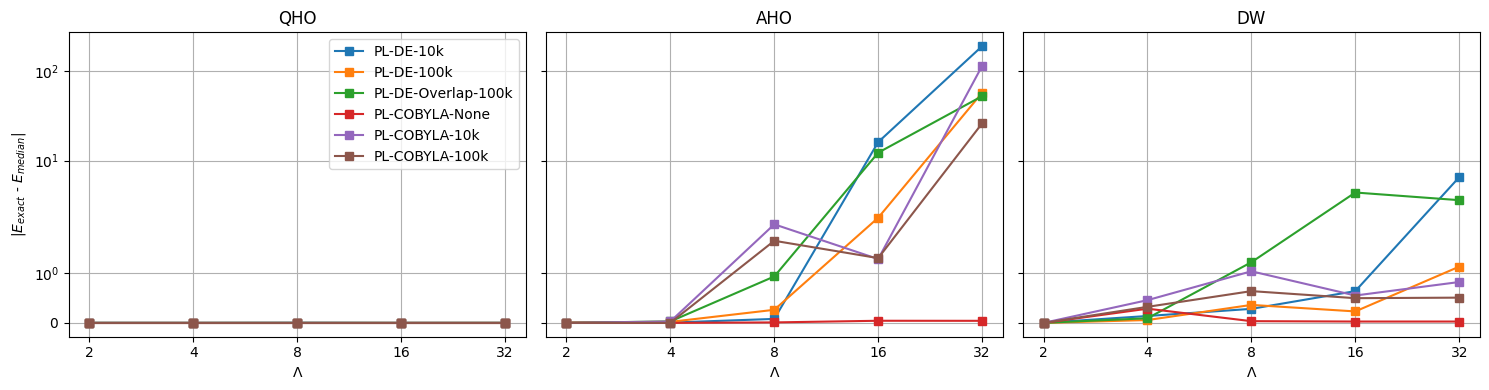

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for label, path in data_paths:

    is_de = False if "COBYLA" in label else True
        
    times, lower_std, upper_std, delta_e, evals, evals_min, evals_max = get_data(path, is_de=is_de, converged_only=True)

    for i, potential in enumerate(potentials):
        axs[i].plot(cutoffs, delta_e[potential], marker='s', label=label)

        axs[i].set_title(f'{potential}')
        axs[i].set_xlabel('$\\Lambda$')
        axs[i].set_xscale('log')
        axs[i].set_yscale('symlog')
        axs[i].set_xticks(cutoffs)
        axs[i].xaxis.set_major_formatter(ticker.ScalarFormatter())
        axs[i].xaxis.set_minor_locator(ticker.NullLocator())
        axs[i].ticklabel_format(style='plain', axis='x')
        axs[i].grid(True)
        
        if i == 0:
            axs[i].set_ylabel('|$E_{exact}$ - $E_{median}$|')
            axs[i].legend()


plt.tight_layout()
plt.show()


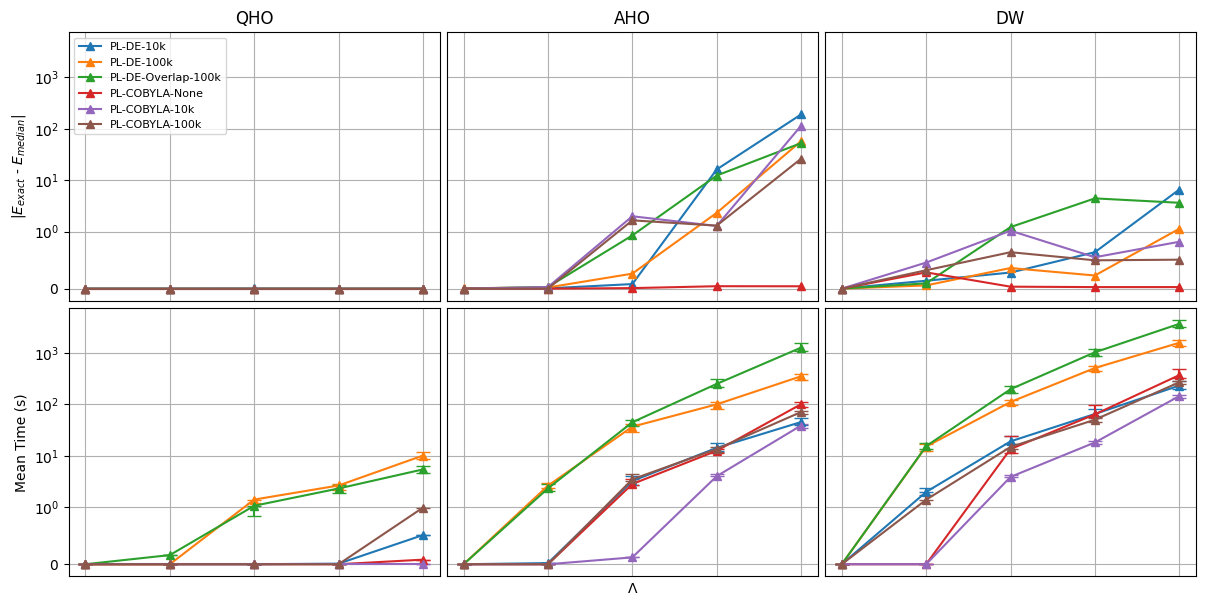

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True, sharex=True)
for label, path in data_paths:

    is_de = False if "COBYLA" in label else True
    times, lower_std, upper_std, delta_e, evals, evals_min, evals_max = get_data(path, is_de=is_de, converged_only=True)

    for i, potential in enumerate(potentials):
        axs = axes[0, i]
        axs.plot(cutoffs, delta_e[potential], marker='^', label=label)
        axs.set_title(f'{potential}')
        axs.set_yscale('symlog', linthresh=1)
        axs.grid(True)
        
        if i == 0:
            axs.set_ylabel('|$E_{exact}$ - $E_{median}$|')
            axs.legend(loc='upper left', fontsize=8)
        else:
            axs.tick_params(axis='y', left=False, right=False, labelleft=False)
      
        axs.tick_params(axis='x', bottom=False, top=False, labelbottom=False)

    for i, potential in enumerate(potentials):
        axs = axes[1, i]
        axs.errorbar(cutoffs, times[potential], yerr=[lower_std[potential], upper_std[potential]],marker='^', capsize=5, label=label)
        
        axs.set_yscale('symlog', linthresh=1)
        axs.grid(True)

        if i == 0:
            axs.set_ylabel('Mean Time (s)')
        else:
            axs.tick_params(axis='y', left=False, right=False, labelleft=False)

        axs.tick_params(axis='x', bottom=False, top=False, labelbottom=False)

axes[1, 1].set_xlabel('$\\Lambda$')
axes[1, 0].set_xscale('log')
axes[1, 0].set_xticks(cutoffs)
axes[1, 0].xaxis.set_major_formatter(ticker.ScalarFormatter())
axes[1, 0].xaxis.set_minor_locator(ticker.NullLocator())

plt.tight_layout(pad=0.5)
plt.show()


In [39]:
qiskit_data_paths = [
                ("PL-COBYLA-None", r"C:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\SUSY\SUSY QM\PennyLane\qml.Sample\COBYLA\Files\None"),
                #("PL-DE-100K", r"C:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\SUSY\SUSY QM\PennyLane\qml.Sample\Qiskit-Vs-PL_pauli\PL\FilesADAPT-Op-100k"),
                ("PL-COBYLA-100k", r"C:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\SUSY\SUSY QM\PennyLane\qml.Sample\COBYLA\Files\100000"),
                ("QK-COBYLA-100k", r"C:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\SUSY\SUSY QM\PennyLane\qml.Sample\Qiskit-Vs-PL_pauli\Qiskit\COBYLA\Files\100000"),
                ("QK-COBYLA-10k", r"C:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\SUSY\SUSY QM\PennyLane\qml.Sample\Qiskit-Vs-PL_pauli\Qiskit\COBYLA\Files\10000"),
                ("QK-COBYLA-None", r"C:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\SUSY\SUSY QM\PennyLane\qml.Sample\Qiskit-Vs-PL_pauli\Qiskit\COBYLA\Files\None")
              ]

potentials = ['QHO', 'AHO', 'DW']

cutoffs = [2, 4, 8, 16, 32]

PL-COBYLA-None {'QHO': [np.float64(0.0), np.float64(2.220446049250313e-16), np.float64(2.7755575615628914e-16), np.float64(2.375877272697835e-16), np.float64(3.219646771412954e-16)], 'AHO': [np.float64(1.6653345369377348e-16), np.float64(1.0824674490095276e-15), np.float64(0.009593949500678073), np.float64(0.04270978233641026), np.float64(0.041536624436476106)], 'DW': [np.float64(3.3306690738754696e-16), np.float64(0.2850823367417462), np.float64(0.03450834977074291), np.float64(0.02723270884908735), np.float64(0.027199700622038914)]}
PL-COBYLA-100k {'QHO': [np.float64(0.0), np.float64(1.1999999997791556e-06), np.float64(2.7755575615628914e-16), np.float64(3.9999999955631084e-07), np.float64(1.4999999996112568e-06)], 'AHO': [np.float64(1.9999999998354667e-06), np.float64(0.0018658422860966806), np.float64(1.648663281342647), np.float64(1.300467979914788), np.float64(26.019347713684876)], 'DW': [np.float64(3.53553390586292e-06), np.float64(0.3219973923090481), np.float64(0.6378014993826

c:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\.venv\lib\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\.venv\lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


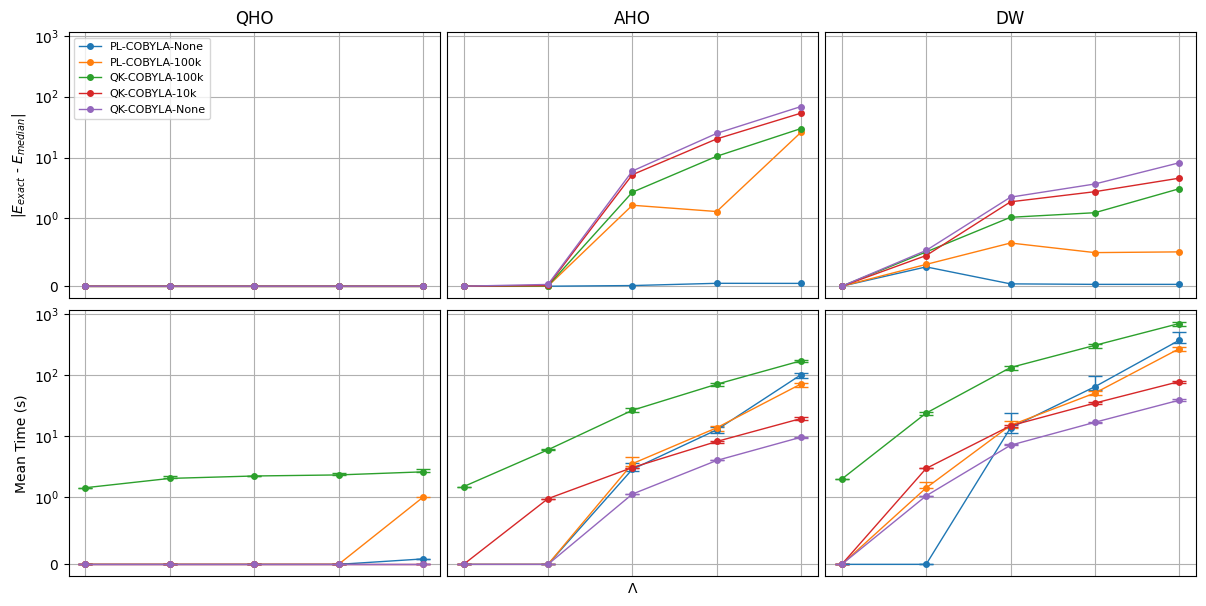

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True, sharex=True)
for label, path in qiskit_data_paths:

    is_de = False if "COBYLA" in label else True
    times, lower_std, upper_std, delta_e, evals, evals_min, evals_max = get_data(path, is_de=is_de, converged_only=True)

    print(label, delta_e)

    for i, potential in enumerate(potentials):
        axs = axes[0, i]
        axs.plot(cutoffs, delta_e[potential], linewidth=1, marker='o', markersize=4, label=label)
        axs.set_title(f'{potential}')
        axs.set_yscale('symlog', linthresh=1)
        axs.grid(True)
        
        if i == 0:
            axs.set_ylabel('|$E_{exact}$ - $E_{median}$|')
            axs.legend(loc='upper left', fontsize=8)
        else:
            axs.tick_params(axis='y', left=False, right=False, labelleft=False)
      
        axs.tick_params(axis='x', bottom=False, top=False, labelbottom=False)

    for i, potential in enumerate(potentials):
        axs = axes[1, i]
        axs.errorbar(cutoffs, times[potential], yerr=[lower_std[potential], upper_std[potential]], linewidth=1, marker='o', markersize=4, capsize=5, label=label)
        
        axs.set_yscale('symlog', linthresh=1)
        axs.grid(True)

        if i == 0:
            axs.set_ylabel('Mean Time (s)')
        else:
            axs.tick_params(axis='y', left=False, right=False, labelleft=False)

        axs.tick_params(axis='x', bottom=False, top=False, labelbottom=False)

axes[1, 1].set_xlabel('$\\Lambda$')
axes[1, 0].set_xscale('log')
axes[1, 0].set_xticks(cutoffs)
axes[1, 0].xaxis.set_major_formatter(ticker.ScalarFormatter())
axes[1, 0].xaxis.set_minor_locator(ticker.NullLocator())

plt.tight_layout(pad=0.5)
plt.show()
